In [1]:
###SASSIE SWIFT DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests
    
##LOCAL DIRECTORY TO SWIFT DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/SWIFT/Final/'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##LOCAL DIRECTORY TO SHIPTRACK (TSG DATA)
ship_dir ='/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/SWIFT/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)

In [2]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
files = sorted(glob.glob(dir_in + '/*.nc'))
for file in files:
    
    #SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
    ds = xr.open_dataset(file)
    #print(ds)
    
    #SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
    variable_info = ds.air_pressure
    #print(variable_info)

In [3]:
##PLAY START AND END DATETIMES (For use with Optional Ice Data)
play1_start = datetime(2022,9,8,8) 
play1_end = datetime(2022,9,13)
play3_start = datetime(2022,9,16)
play3_end = datetime(2022,9,18)
play4_start = datetime(2022,9,19)
play4_end  = datetime(2022,9,23)
play5_start = datetime(2022,9,25)
play5_end = datetime(2022,9,29)

In [4]:
##USE THIS TO PLOT THE SWIFT TRACKS ON THE WHOLE CAMPAIGN MAP 
def map_SWIFT(ship_track=True,bathymetry_data=True,ice_data=False):
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS AND SHIP TRACK  
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-144
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) 
    ax.set_title('SWIFT Tracks',fontsize=22,pad=1) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,74,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK')
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK')
    plt.legend(loc=2)
    
    ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
        
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(xr.open_dataset(files[0])['time'].values[0],'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(xr.open_dataset(files[-1])['time'].values[-1],'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
        
    
    
    
    ##APPLY THE TIME AND LOCATION DATA IN EACH SWIFT FILE 
    for file in files:
        ds_swift = xr.open_dataset(file)
        swift_time = np.squeeze(ds_swift['time'])
        swift_lat = np.squeeze(ds_swift['latitude'])
        swift_lon = np.squeeze(ds_swift['longitude']) 
        
        casts = ax.scatter(swift_lon,swift_lat,s = 1,c = swift_time,cmap = 'jet',transform=cartopy.crs.PlateCarree(),zorder=2,vmin=1.6626E18,vmax=1.6647E18)
        
    
                        
    cbar = fig.colorbar(casts, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(xr.open_dataset(files[0])['time'].values[0].astype('int64'),xr.open_dataset(files[-1])['time'].values[-1].astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
        
    ##SAVE THE FIGURE 
    if not os.path.exists(fig_dir+'/tracks'):
        os.makedirs(fig_dir+'/tracks')
    
    print('Saving Output Image:  '+fig_dir+'/tracks/SWIFT_track_map.png')
    plt.savefig(fig_dir+'/tracks/SWIFT_track_map.png',dpi='figure',format='png')

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/SWIFT//tracks/SWIFT_track_map.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


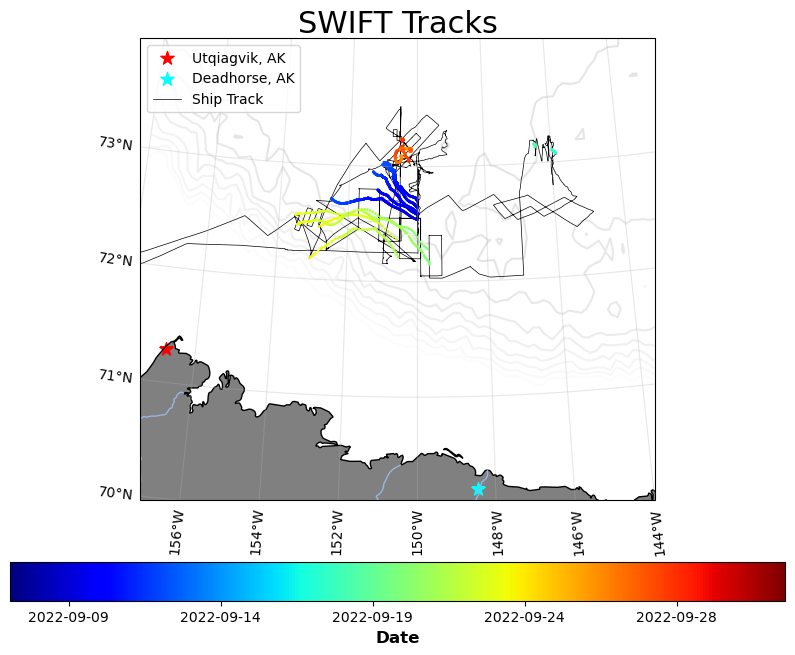

In [5]:
map_SWIFT()

In [ ]:
def define_var_attributes(var): 
    if var == 'wave_energy':
        var_label = 'Wave Energy (m$^{2}$s)'
        colormap = 'spring'
    if var == 'spectral_directional_moment_east':
        var_label = 'Eastern Spectral Directional Moment (m$^{2}$s)'
        colormap = 'PiYG'
    if var == 'spectral_directional_moment_north': 
        colormap = 'BrBG'
        var_label = 'Northern Spectral Directional Moment (m$^{2}$s)'
    if var == 'spectral_directional_moment_east_west': 
        colormap = 'PRGn'
        var_label = 'East-West Spectral Directional Moment (m$^{2}$s)'
    if var == 'spectral_directional_moment_north_south': 
        colormap = 'PuOr'
        var_label = 'North-South Spectral Directional Moment (m$^{2}$s)'
    if var == 'turbulent_dissipation_rate':
        var_label = 'Turbulent Dissipation Rate'
        colormap = 'hot'
    if var == 'water_temperature':
        var_label = 'Water Temperature ($^{\circ}$C)'
        colormap = 'plasma'
    if var == 'air_temperature':
        var_label = 'Air Temperature ($^{\circ}$C)'
        colormap = 'magma'
    if var == 'air_pressure':
        var_label = 'Air Pressure (hPa)'
        colormap = 'Blues'
    if var == 'air_pressure_stdev':
        var_label = 'Air Pressure Standard Deviation (hPa)'
        colormap = 'Blues'
    if var == 'salinity':
        var_label = 'Salinity'
        colormap = 'viridis'
    if var == 'surface_wave_height':
        var_label = 'Surface Wave Height (m)'
        colormap = 'autumn'
    if var == 'surface_wave_period':
        var_label = 'Surface Wave Period (s)'
        colormap = 'cool'
    if var == 'surface_wave_direction':
        var_label = 'Surface Wave Direction From North (Degree)'
        colormap = 'twilight'
    if var == 'drift_speed_stdev':
        var_label = 'Drift Speed Standard Deviation (m/s)'
        colormap = 'cividis' 
    if var == 'drift_speed':
        var_label = 'Drift Speed (m/s)'
        colormap = 'cividis' 
    if var == 'drift_direction_stdev':
        var_label = 'Drift Direction from North Standard Deviation (m/s)'
        colormap = 'twilight' 
    if var == 'drift_direction':
        var_label = 'Drift Direction from North (m/s)'
        colormap = 'twilight' 
    if var == 'wind_speed_stdev':
        var_label = 'Wind Speed Standard Deviation (m/s)'
        colormap = 'cividis' 
    if var == 'wind_speed':
        var_label = 'Wind Speed (m/s)'
        colormap = 'cividis'
    if var == 'wind_direction_stdev':
        var_label = 'Wind Direction from North Standard Deviation (Degree)'
        colormap = 'twilight' 
    if var == 'wind_direction':
        var_label = 'Wind Direction from North (Degree)'
        colormap = 'twilight' 
    if var == 'drift_speed_stdev':
        var_label = 'Drift Speed Standard Deviation (m/s)'
        colormap = 'cividis' 
        
    return colormap,var_label

In [ ]:
##USE THIS TO PLOT SWIFT TRACK with Surface Variable (no depth or frequency dimension) 
def plot_swift_track(swift_numbers,play,var,var_min,var_max,ship_track=True,bathymetry_data=True,ice_data=False):
    
    #GET LAT AND LON RANGE OF SWIFTS
    file = dir_in+'SASSIE_Fall_2022_SWIFT'+str(swift_numbers[0])+'_play'+str(play)+'.nc'
    ds = xr.open_dataset(file,engine='netcdf4')
    SWIFT_lat = ds['latitude']
    SWIFT_lon = ds['longitude']

        
    ##CREATE A MAP WITH LAND AND CITY MARKERS
    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    if (play ==1):
        latmin = min(SWIFT_lat.values)-0.1
        latmax = max(SWIFT_lat.values)+0.3
        lonmin = min(SWIFT_lon.values)-1.5
        lonmax = max(SWIFT_lon.values)+0.1
        start_time = play1_start
        end_time=play1_end
    if (play == '3a') | (play =='3b')|(play==5):
        latmin = min(SWIFT_lat.values)-0.1
        latmax = max(SWIFT_lat.values)+0.1
        lonmin = min(SWIFT_lon.values)-0.1
        lonmax = max(SWIFT_lon.values)+0.1 
        start_time = play3_start
        end_time = play3_end
    if (play==4):
        latmin = min(SWIFT_lat.values)-0.3
        latmax = max(SWIFT_lat.values)+0.1
        lonmin = min(SWIFT_lon.values)-0.9
        lonmax = max(SWIFT_lon.values)+1
        start_time = play4_start
        end_time = play4_end
    if (play==5):
        latmin = min(SWIFT_lat.values)-0.1
        latmax = max(SWIFT_lat.values)+0.1
        lonmin = min(SWIFT_lon.values)-0.3
        lonmax = max(SWIFT_lon.values)+0.1
        start_time = play5_start
        end_time = play5_end
    [colormap,var_label] = define_var_attributes(var)
      
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    
    if len(swift_numbers)>1:
        ax.set_title('SWIFT '+var_label+'Readings from Play '+str(play),fontsize=15)
    if len(swift_numbers) == 1:
        ax.set_title('SWIFT '+str(swift_numbers[0])+' '+var_label+'Readings from Play'+str(play),fontsize=15)
        
    xticks = list(np.linspace(lonmin,lonmax,3))
    yticks = list(np.linspace(latmin,latmax,3))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.around(yticks,2))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.around(xticks,1))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK')
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK')
    
    
    
    ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
        
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
        
    
    ##APPLY SWIFT DATA 
    for swift in swift_numbers:
        file = dir_in+'SASSIE_Fall_2022_SWIFT'+str(swift)+'_play'+str(play)+'.nc'
        ds = xr.open_dataset(file,engine='netcdf4')
        SWIFT_lat = ds['latitude']
        SWIFT_lon = ds['longitude']
        SWIFT_time = ds['time']
        SWIFT_var = ds[var]

        swift_track = ax.scatter(SWIFT_lon, 
                     SWIFT_lat,s=5, 
                     c=SWIFT_var,cmap=colormap,
                       transform=cartopy.crs.PlateCarree(),
                          vmin = var_min,
                          vmax = var_max,zorder = 2)

        swift_start = ax.scatter(SWIFT_lon[0], 
                    SWIFT_lat[0],s=20, 
                    c='cyan',
                     transform=cartopy.crs.PlateCarree(),zorder = 3)
        swift_end = ax.scatter(SWIFT_lon[-1], 
                    SWIFT_lat[-1],s=80, 
                    c='cyan',marker = '*',
                     transform=cartopy.crs.PlateCarree(),zorder = 3)
        if play ==1:
            ax.text((SWIFT_lon[-1]-0.2),SWIFT_lat[-1]+0.02,s='Swift '+str(swift),transform=cartopy.crs.PlateCarree())
        if play=='3a':
            ax.text((SWIFT_lon[-1]-0.1),SWIFT_lat[-1]+0.0,s='Swift '+str(swift),transform=cartopy.crs.PlateCarree())
        if (play=='3b')|(play==5):
            ax.text((SWIFT_lon[-1]-0),SWIFT_lat[-1]+0.0,s='Swift '+str(swift),transform=cartopy.crs.PlateCarree())
        if play==4:
            ax.text((SWIFT_lon[-1]-0),SWIFT_lat[-1]-0.05,s='Swift '+str(swift),transform=cartopy.crs.PlateCarree())

    matplotlib.pyplot.colorbar(swift_track, ax=ax, orientation="vertical", pad=0.1).set_label(label=var_label,size='large',weight='bold')
    
    #SAVE FIGURE
    if not os.path.exists(fig_dir+var):
        os.makedirs(fig_dir+var)
    if len(swift_numbers)>1:
        print('Saving Output Image:  '+fig_dir+var+'/SWIFT_play_'+str(play)+'_'+var+'.png')
        plt.savefig(fig_dir+var+'/SWIFT_play_'+str(play)+'_'+var+'.png',dpi='figure',format='png')
    if len(swift_numbers) == 1: 
        print('Saving Output Image:  '+fig_dir+var+'/SWIFT_'+str(swift_numbers[0])+'_play_'+str(play)+'_'+var+'.png')
        plt.savefig(fig_dir+var+'/SWIFT_play_'+str(play)+'_'+var+'.png',dpi='figure',format='png')
    
    
    

In [ ]:
plot_swift_track([12,13,15,17],1,'salinity',24,27)
plot_swift_track([16,17],'3a','salinity',24,27)
plot_swift_track([16,17],'3b','salinity',24,27)
plot_swift_track([12,15,16,17],4,'salinity',24,27)
plot_swift_track([12,15,16,17],5,'salinity',24,27)


In [ ]:
plot_swift_track([13],1,'water_temperature',-1,3)
plot_swift_track([15],1,'water_temperature',-1,3)
plot_swift_track([17],1,'water_temperature',-1,3)

In [ ]:
plot_swift_track([12],1,'salinity',23.5,25)
plot_swift_track([13],1,'salinity',23.5,25)
plot_swift_track([15],1,'salinity',23.5,25)
plot_swift_track([17],1,'salinity',23.5,25)

In [ ]:
##USE THIS TO PLOT SWIFT SPECTRAL DENSITY (for variables with a frequency dimension) 
def plot_swift_spectra(swift_number,play,var,var_min,var_max):
    
    ##SWIFT DATA
    file = dir_in+'SASSIE_Fall_2022_SWIFT'+str(swift_number)+'_play'+str(play)+'.nc'
    ds = xr.open_dataset(file,engine='netcdf4')
    SWIFT_lat = ds['latitude']
    SWIFT_lon = ds['longitude']
    SWIFT_freq = ds['frequency']
    SWIFT_pd = 1/SWIFT_freq
    SWIFT_var = ds[var]
    
    [lat,pd] = np.meshgrid(SWIFT_lat,SWIFT_pd)
    [lon,pd] = np.meshgrid(SWIFT_lon,SWIFT_pd)
     
    [colormap,var_label] = define_var_attributes(var)

    
    ##CREATE 3D PLOT     
    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(SWIFT_lat.values)-0.1
    latmax = max(SWIFT_lat.values)+0.1
    lonmin = min(SWIFT_lon.values)-0.1
    lonmax = max(SWIFT_lon.values)+0.1
    pmin = min(SWIFT_pd.values)
    pmax = max(SWIFT_pd.values)
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False  
    
    ax.set_title('SWIFT '+str(swift_number)+' '+var_label+' '+'Readings from Play'+' '+str(play),fontsize=15,pad=None)
    
    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(np.log(pmin),np.log(pmax));
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    zticks = list(np.linspace(np.log(pmin),np.log(pmax),4))
    ax.set_zticks(np.around(zticks,2))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Log(Period (s))')
    
    ax.view_init(210,70)
 
    ##APPLY SWIFT DATA 
    a = ax.scatter(lon,lat,np.log(pd),c=(SWIFT_var.values),cmap = colormap,s=2,zorder=1,vmin=var_min,vmax=var_max)    
    fig.colorbar(a,label = var_label)
    
    #SAVE FIGURE
    if not os.path.exists(fig_dir+var):
        os.makedirs(fig_dir+var)
    print('Saving Output Image:  '+fig_dir+var+'/'+'SWIFT'+str(swift_number)+'play'+str(play)+'_'+var+'.png')
    plt.savefig(fig_dir+var+'/'+'SWIFT'+str(swift_number)+'play'+str(play)+'_'+var+'.png',dpi='figure',format='png')


In [ ]:
plot_swift_spectra(12,1,'spectral_directional_moment_east',0,0.5)
plot_swift_spectra(13,1,'wave_energy',0,0.1)
plot_swift_spectra(15,1,'wave_energy',0,0.5)
plot_swift_spectra(17,1,'wave_energy',0,0.1)

In [ ]:
##USE THIS TO PLOT VARIABLES WITH A DEPTH DIMENSION (only works for swifts 12 and 17, which had vertical profilers)

def plot_tke_dissipation(swift_number,play):
    
    var = 'turbulent_dissipation_rate'
    colormap,var_label = define_var_attributes(var)
    
    ##SWIFT DATA
    file = dir_in+'SASSIE_Fall_2022_SWIFT'+str(swift_number)+'_play'+str(play)+'.nc'
    ds = xr.open_dataset(file,engine='netcdf4')
    SWIFT_lat = ds['latitude']
    SWIFT_lon = ds['longitude']
    SWIFT_depth = ds['depth']
    SWIFT_var = ds[var]
    
    [lat,depth] = np.meshgrid(SWIFT_lat,SWIFT_depth)
    [lon,depth] = np.meshgrid(SWIFT_lon,SWIFT_depth)
    
    ##CREATE 3D PLOT 
    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140 
    latmin = min(SWIFT_lat.values)-0.1
    latmax = max(SWIFT_lat.values)+0.1
    lonmin = min(SWIFT_lon.values)-0.1
    lonmax = max(SWIFT_lon.values)+0.1
    dmin = min(SWIFT_depth.values)
    dmax = max(SWIFT_depth.values)
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False    
    
    ax.set_title('SWIFT '+str(swift_number)+' '+var_label+' '+'Readings from Play'+' '+str(play),fontsize=15,pad=None)
    
    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    zticks = list(np.linspace(dmin,dmax,4))
    ax.set_zticks(np.around(zticks,2))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (m)')
    
    ax.view_init(210,60)
    
    
    ##APPLY SWIFT DATA
    a = ax.scatter(lon,lat,depth,c=(SWIFT_var.values),cmap = colormap,s=2,zorder=1,vmin=0)    
    fig.colorbar(a,label = var_label)

    #SAVE FIGURE 
    if not os.path.exists(fig_dir+var):
        os.makedirs(fig_dir+var)
    print('Saving Output Image:  '+fig_dir+var+'/'+'SWIFT'+str(swift_number)+'play'+str(play)+'_'+'turbulent_dissipation_rate'+'.png')
    plt.savefig(fig_dir+var+'/'+'SWIFT'+str(swift_number)+'play'+str(play)+'_'+'turbulent_dissipation_rate'+'.png',dpi='figure',format='png')

In [ ]:
plot_tke_dissipation(12,1)
plot_tke_dissipation(12,4)
plot_tke_dissipation(12,5)
plot_tke_dissipation(17,1)
plot_tke_dissipation(17,4)
plot_tke_dissipation(17,5)

In [ ]:
#For making a time series of surface level variables only. 
def plot_swift_timeseries(swift_number,play,var1,var2,var3): 
    
    #SECLECT AND LOAD JET SSP DATA
    file = dir_in+'SASSIE_Fall_2022_SWIFT'+str(swift_number)+'_play'+str(play)+'.nc'
    ds = xr.open_dataset(file)
    time_data = ds['time']
    [colormap,var1_label] = define_var_attributes(var1)
    [colormap,var2_label] = define_var_attributes(var2)
    [colormap,var3_label] = define_var_attributes(var3)
    var1_data = ds[var1]
    var2_data = ds[var2]
    var3_data = ds[var3]
        
    #MAKE A THREE PANELED TIME SERIES PLOT
    fig,axs = plt.subplots(3,sharex=True)
    
    axs[0].plot(time_data,var1_data,linewidth=0.4,c='black')
    axs[0].set_ylabel(var1_label,fontsize=8)
    axs[1].plot(time_data,var2_data,linewidth=0.4,c='black')
    axs[1].set_ylabel(var2_label,fontsize=8)
    axs[2].plot(time_data,var3_data,linewidth=0.4,c='black')
    axs[2].set_ylabel(var3_label,fontsize=8)
    
    
    axs[2].set(xlabel = 'Date')
    plt.xticks(pd.date_range(start=time_data.values[0],end=time_data.values[-1],periods=3))
    fig.suptitle(var1_label+', '+var2_label+', and '+var3_label+' Data from SWIFT '+str(swift_number)+' Play '+str(play),fontsize=10)
    
    #Ideal location for legend may vary depending on which data is plotted 
    if any([var1_data.ndim>1,var2_data.ndim>1,var3_data.ndim>1]):
        #axs[1].legend(loc=1,bbox_to_anchor=(1.25,1.0))
        axs[0].legend(loc=4,ncol=4)

    
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'/timeseries'):
        os.makedirs(fig_dir+'/timeseries')
    print('Saving Output Image:  '+fig_dir+'/timeseries/SWIFT'+str(swift_number)+'_Play'+str(play)+'_'+var1+'_'+var2+'_'+var3+'.png')
    plt.savefig(fig_dir+'/timeseries/SWIFT'+str(swift_number)+'_Play'+str(play)+'_'+var1+'_'+var2+'_'+var3+'.png',dpi='figure',format='png')
    

In [ ]:
plot_swift_timeseries(16,1,'salinity','water_temperature','wind_speed')